In [9]:
# Dataset -2 : Random Forest Stroke Prediction Dataset

# Step 1: Import Libraries
# Explanation:
# We import similar libraries as before, but we've added:
# - OneHotEncoder: For handling categorical features that are not ordinal.
# - SimpleImputer: For handling missing values in numerical columns.
# - ColumnTransformer: To apply different preprocessing steps to different columns.
# - Pipeline: To streamline the preprocessing and model training steps.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

In [10]:
# Step 2: Load the Dataset
# Explanation:
# This cell loads the healthcare-dataset-stroke-data.csv file into a pandas DataFrame.
# It prints the first few rows and provides information about the data types and missing values.
# We specifically check for missing values as the bmi column is known to have them. Ensure you have
# downloaded this dataset and placed it in the correct directory.

# Load the Stroke Prediction Dataset
try:
    stroke_data = pd.read_csv('healthcare-dataset-stroke-data.csv')
except FileNotFoundError:
    print("Error: healthcare-dataset-stroke-data.csv not found. Make sure the file is in the correct location.")
    exit()

# Display the first few rows
print("First 5 rows of the Stroke Prediction dataset:")
print(stroke_data.head())

# Get dataset information
print("\nStroke Prediction dataset info:")
stroke_data.info()

# Check for missing values
print("\nMissing values before handling:")
print(stroke_data.isnull().sum())

First 5 rows of the Stroke Prediction dataset:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  

Stroke P

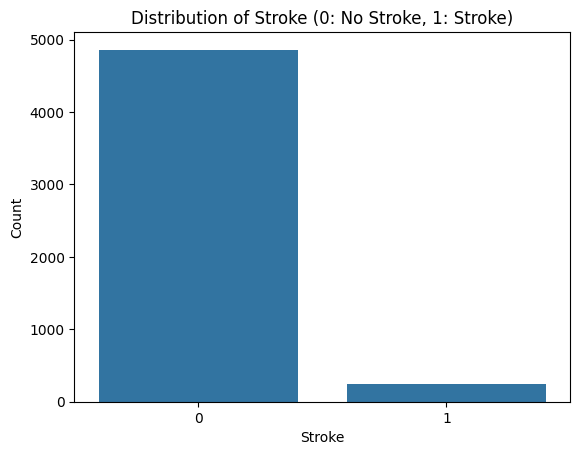


Numerical columns: Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')
Categorical columns: Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

Processed X_train shape: (3576, 20)
Processed X_test shape: (1533, 20)


In [11]:
# Step 3: Data Exploration and Preprocessing
# Explanation:
# - Target Variable Exploration: Visualizes the distribution of the stroke column.
#   Notice the potential class imbalance.
# - Handle 'Other' Gender: Removes rows where the gender is 'Other' for simplicity.
# - Separate Features and Target: Separates the features (X) and the target variable (stroke).
#   The id column is also dropped as it's not a predictive feature.
# - Identify Column Types: Identifies numerical and categorical columns.
## Create Preprocessing Pipelines:
# - Numerical Pipeline: Uses SimpleImputer to fill missing values in numerical columns (specifically bmi)
#   with the mean.
# - Categorical Pipeline: Uses OneHotEncoder to convert categorical features into a numerical format.
#   handle_unknown='ignore' is used to avoid errors if unknown categories appear in the test set.
# - ColumnTransformer: Applies the appropriate preprocessing pipeline to the corresponding columns.
# - Split Data: Splits the data into training and testing sets, maintaining the class proportions (stratify=y).
# - Apply Preprocessing: Fits the preprocessor on the training data and then transforms both the
#   training and testing data.
# - Convert to DataFrames (Optional): Converts the processed NumPy arrays back into DataFrames with meaningful column names, which can be useful for debugging or further analysis.

# Explore the target variable distribution
sns.countplot(x='stroke', data=stroke_data)
plt.title('Distribution of Stroke (0: No Stroke, 1: Stroke)')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.show()

# Handle 'Other' gender (if any) - for simplicity, we can drop these rows
stroke_data = stroke_data[stroke_data['gender'] != 'Other']

# Separate features (X) and target (y)
X = stroke_data.drop(['id', 'stroke'], axis=1)
y = stroke_data['stroke']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include='object').columns

print("\nNumerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')) # Handle missing 'bmi'
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply preprocessing to training and testing sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert processed data back to DataFrames (optional, but can be helpful for inspection)
X_train_processed = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())
X_test_processed = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

print("\nProcessed X_train shape:", X_train_processed.shape)
print("Processed X_test shape:", X_test_processed.shape)

In [12]:
# Step 4: Initialize and Train the Random Forest Model
# Explanation:
# This cell initializes a RandomForestClassifier with initial hyperparameters, including
# class_weight='balanced' to address the class imbalance observed in the 'stroke' column.
# The model is then trained using the preprocessed training data.

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train the Random Forest model on the processed training data
rf_model.fit(X_train_processed, y_train)

print("\nRandom Forest model trained on processed data.")


Random Forest model trained on processed data.



Accuracy of the Random Forest model: 0.9504

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533


Confusion Matrix:


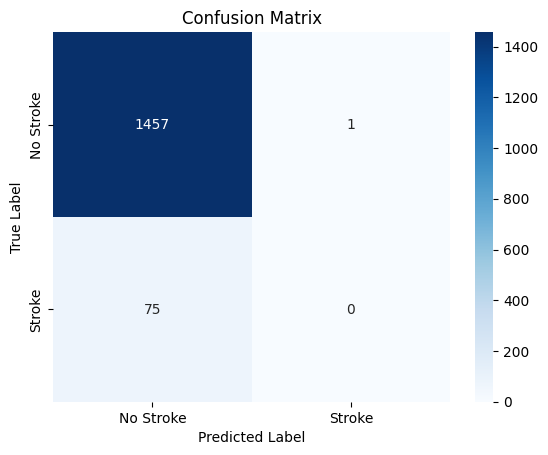

In [13]:
# Step 5: Make Predictions and Evaluate the Model
# Explanation:
# This cell makes predictions on the preprocessed test data using the trained Random Forest model
# and evaluates its performance using accuracy, classification report, and confusion matrix.

# Make predictions on the processed test data
y_pred = rf_model.predict(X_test_processed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy of the Random Forest model: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

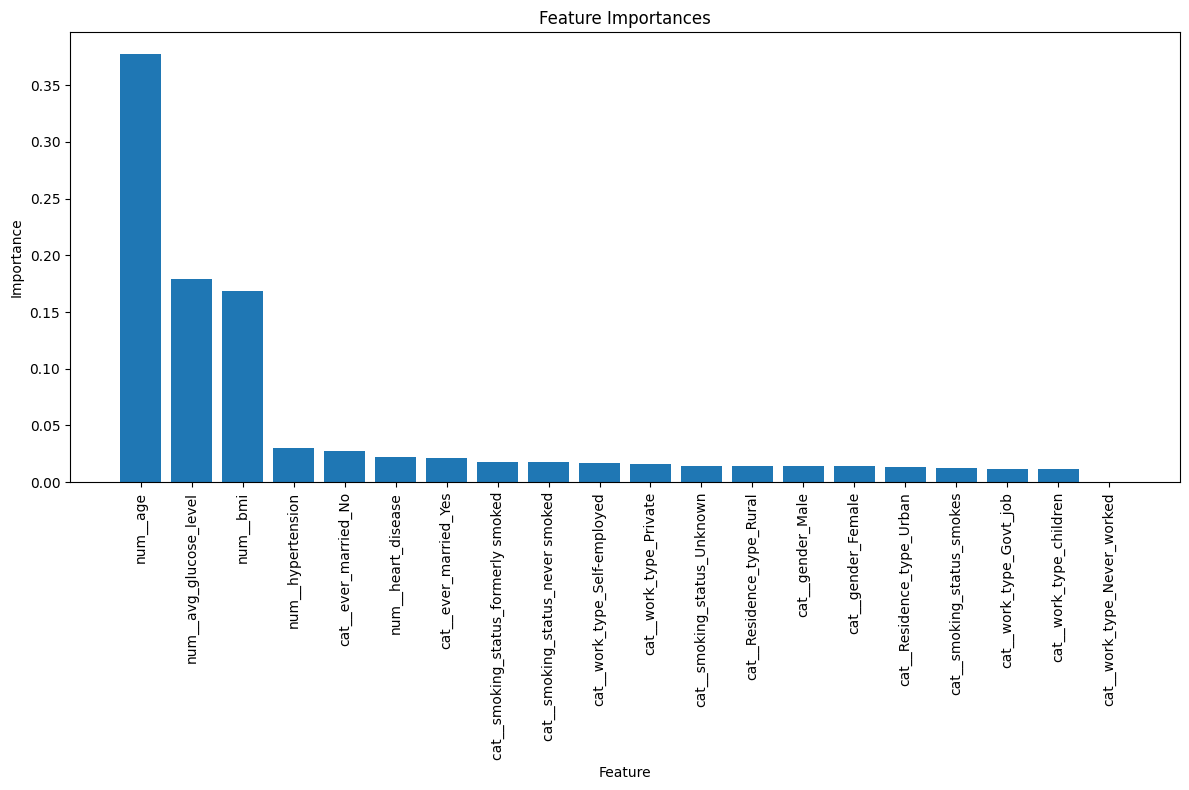

In [14]:
# Step 6: Analyze Feature Importance
# Explanation:
# This cell extracts and visualizes the feature importances from the trained Random Forest model,
# showing which preprocessed features were most important in predicting stroke risk.

# Analyze feature importance
feature_importances = rf_model.feature_importances_
feature_names = X_train_processed.columns

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_train_processed.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train_processed.shape[1]), feature_names[sorted_indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [15]:
# Step 7: Hyperparameter Tuning using GridSearchCV
# Explanation:
# This cell sets up a Pipeline that combines the preprocessing steps and the Random Forest classifier.
# It then uses GridSearchCV to find the best hyperparameters for the entire pipeline (including the Random
# Forest model) using cross-validation and the F1-score as the evaluation metric.

# Create a pipeline for preprocessing and model training
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))])

# Define the parameter grid to search
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("\nBest Hyperparameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

# Get the best model
best_rf_model = grid_search.best_estimator_


Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 50}
Best F1-score: 0.24529841974663705



Accuracy of the Optimized Random Forest model: 0.8376

Classification Report (Optimized Model):
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1458
           1       0.17      0.60      0.27        75

    accuracy                           0.84      1533
   macro avg       0.57      0.72      0.59      1533
weighted avg       0.94      0.84      0.88      1533


Confusion Matrix (Optimized Model):


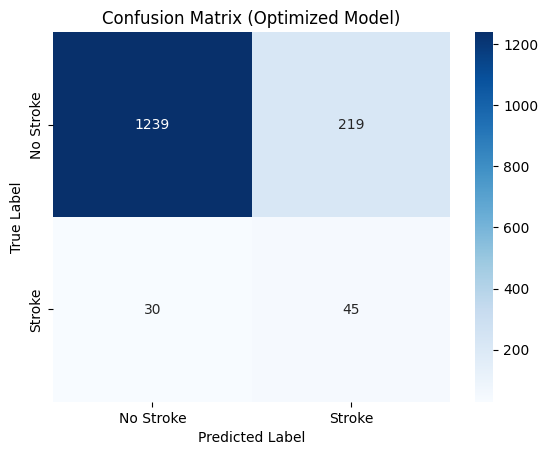


Cross-validation F1-scores for the best model: [0.26605505 0.25806452 0.24793388 0.28436019 0.26315789]
Mean cross-validation F1-score of the best model: 0.2639


In [16]:
# Step 8: Evaluate the Optimized Model
# Explanation:
# This cell evaluates the performance of the optimized Random Forest model (obtained from GridSearchCV)
# on the test data using the same metrics as before. It also performs cross-validation on the entire
# dataset with the best model to get a more reliable estimate of its generalization performance.

# Make predictions using the best model
y_pred_best = best_rf_model.predict(X_test)

# Evaluate the optimized model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"\nAccuracy of the Optimized Random Forest model: {accuracy_best:.4f}")

print("\nClassification Report (Optimized Model):")
print(classification_report(y_test, y_pred_best))

print("\nConfusion Matrix (Optimized Model):")
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Optimized Model)')
plt.show()

# Perform cross-validation on the best model
cv_scores_best = cross_val_score(best_rf_model, X, y, cv=5, scoring='f1')
print(f"\nCross-validation F1-scores for the best model: {cv_scores_best}")
print(f"Mean cross-validation F1-score of the best model: {cv_scores_best.mean():.4f}")